In [5]:
# Multi-class classification
import re
from pymongo import MongoClient
from pprint import pprint
import pandas as pd
from wordcloud import WordCloud
import collections
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, DBSCAN
from tensorflow import keras
import tensorflow as tf
import keras
from keras.datasets import mnist
from keras import models, layers
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [33]:
# Functions used in the notebook
def mongo_connect(server_name: str) -> MongoClient:
    """Creates connection to the MongoDB database with given server name."""
    client = MongoClient(server_name)
    db = client.twitter_db
    return db

word_lemm = WordNetLemmatizer()
stopwords_eng = stopwords.words('english')

stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

# Tweet preprocessing
def preprocess_texts(text_list: pd.DataFrame):
    """Processes text to remove all unwanted words and symbols."""

    # Lowercase the tweets
    text_list['processed_tweet'] = text_list['tweet_text'].str.lower()

    # Regex patterns
    url_pattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    user_pattern       = '@[^\s]+'
    alpha_pattern      = "[^a-zA-Z]"
    sequence_pattern   = r"(.)\1\1+"
    seq_replace_pattern = r"\1\1"

    # Remove URLs from the tweet text
    text_list['processed_tweet'] = [re.sub(url_pattern, ' ', str(x))
                                    for x in text_list['processed_tweet']]
    # Remove username from the tweet text
    text_list['processed_tweet'] = [re.sub(user_pattern, ' ', str(x))
                                    for x in text_list['processed_tweet']]
    # Remove all non-alphanumeric symbols
    text_list['processed_tweet'] = [re.sub(alpha_pattern, ' ', str(x))
                                    for x in text_list['processed_tweet']]
    # Replace all 3 or more consecutive letters with 2 letters
    text_list['processed_tweet'] = [re.sub(sequence_pattern, seq_replace_pattern, str(x))
                                    for x in text_list['processed_tweet']]

    
    full_tweet_list = []
    for x in text_list['processed_tweet']:
        full_tweet = ''
        for word in x.split():
            if word not in stopwordlist:
                word = word_lemm.lemmatize(word)
                full_tweet += (word + ' ')
        full_tweet_list.append(full_tweet)

    text_list['processed_tweet'] = full_tweet_list

    return text_list

def plot_word_cloud(text):
    wordcloud_instance = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords=None,
                min_font_size = 10).generate(text) 
             
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud_instance) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()

def plot_word_cloud_for_category(bbc_text_df, category):
    text_df = bbc_text_df.loc[bbc_text_df['archetype'] == str(category)]
    texts = ''
    for index, item in text_df.iterrows():
        texts = texts + ' ' + item['processed_tweet']
    
    plot_word_cloud(texts)
    
# Function to show training results
def show_training_results(model, num_clusters):
    order_centroids = model.cluster_centers_.argsort()[:,::-1]
    terms = vectorizer.get_feature_names()
    
    for i in range(num_clusters):
        print("Cluster %d:" % i)
        for ind in order_centroids[i, :100]:
            print(' %s' % terms[ind])
            
# Function to test the model
def test_prediction(model, tweet_number):
    print("Prediction")
    try:
        to_predict = vectorizer.transform([df_tweets['processed_tweet'][tweet_number]])
    except:
        print("Exception, wrong number")
        to_predict = vectorizer.transform([df_tweets['processed_tweet'][0]])
    finally:
        prediction = model.predict(to_predict)
        print(prediction)
        
def training_accuracy(model, df):
    result = 0
    predictions = model.predict(text_test)
    for i in range(text_test.shape[0]):
        if df['archetype'][i] == predictions[i]:
            result +=1
    return result

In [34]:
# Create DataFrame with classified tweets (autolabelling)
archetype_list = ['artist',
                 'caregiver',
                 'everyman',
                 'explorer',
                 'guru',
                 'hero',
                 'innocent',
                 'jester',
                 'magician',
                 'rebel',
                 'ruler',
                 'seducer']


df_tweets = pd.DataFrame(columns=['_id',
                                  'tweet_text',
                                  'username',
                                  'created_at'])

# Connect to local database
db = mongo_connect('localhost')

for archetype in archetype_list:
    # Create a cursor for acquiring all posts from the collection
    cursor = db[archetype].find()
    
    df_archetype = pd.DataFrame(list(cursor))
    df_archetype['archetype'] = archetype
    df_tweets = df_tweets.append(df_archetype, ignore_index=True)
    
print(df_tweets.shape)

# Preprocess the tweets and create a categorical label
df_tweets = preprocess_texts(df_tweets)

# Create categorical label
y_label = to_categorical(df_tweets['archetype'].factorize()[0])

(26354, 5)


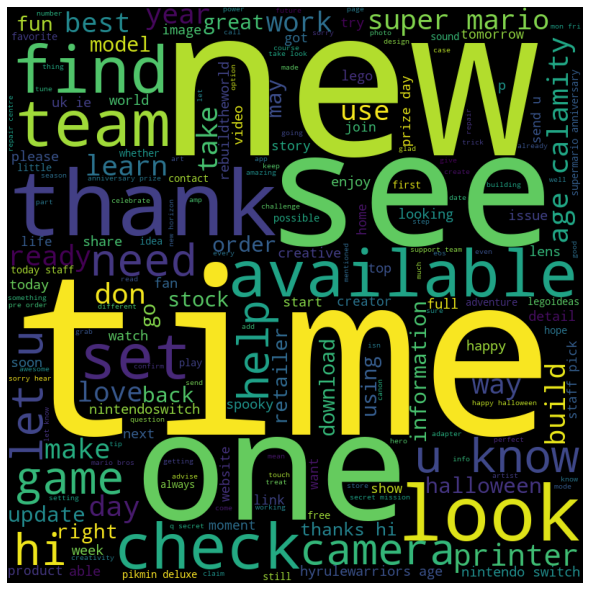

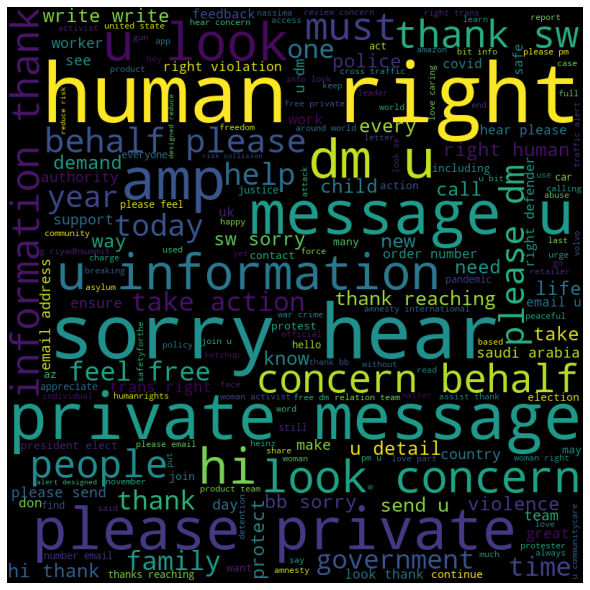

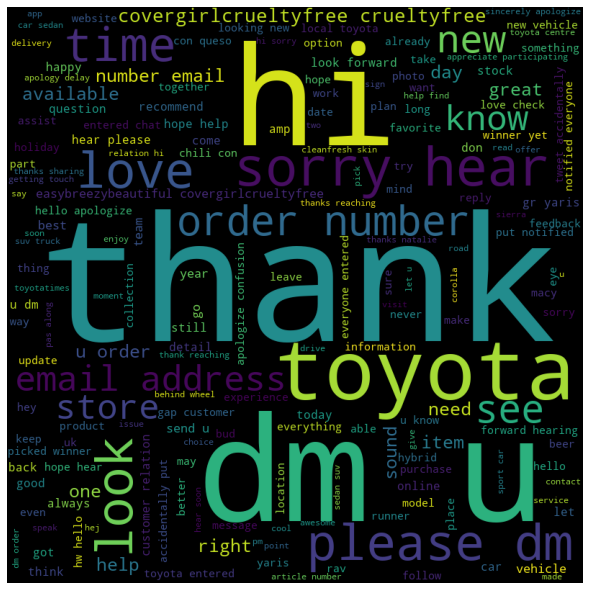

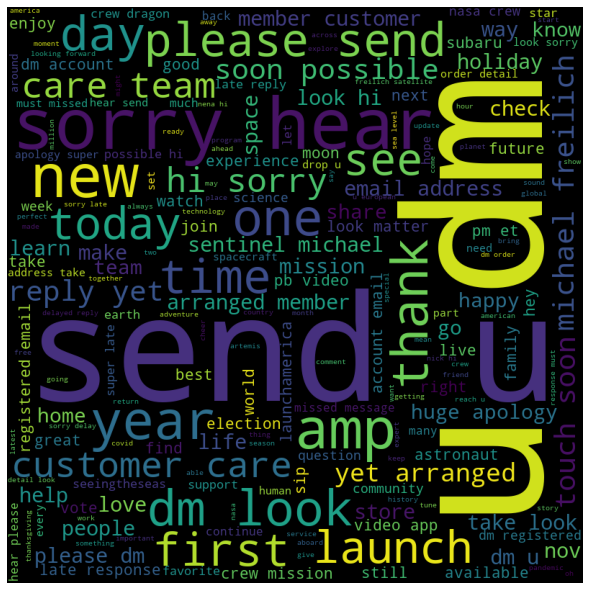

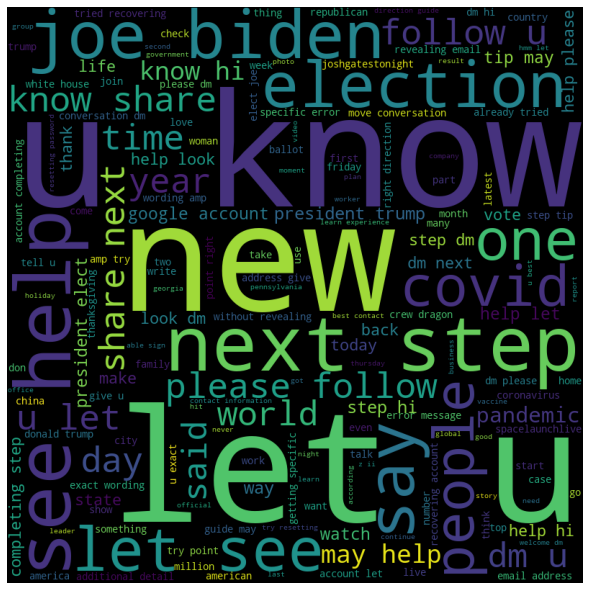

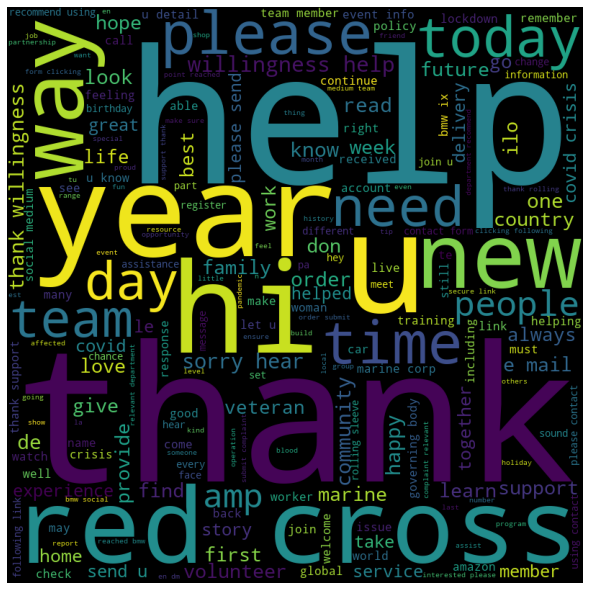

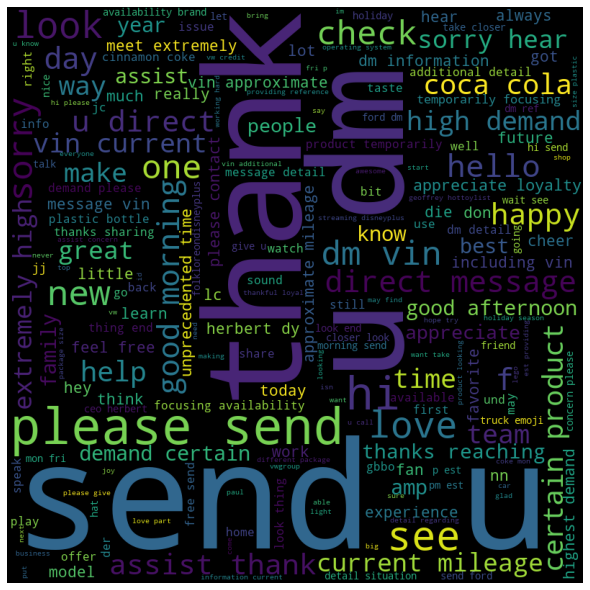

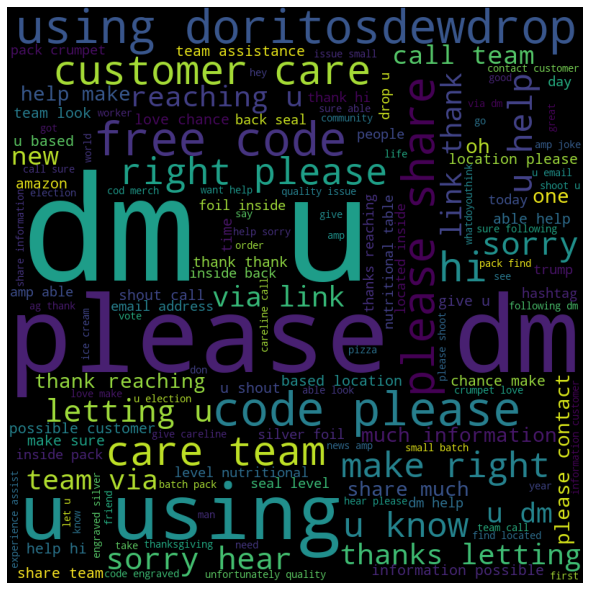

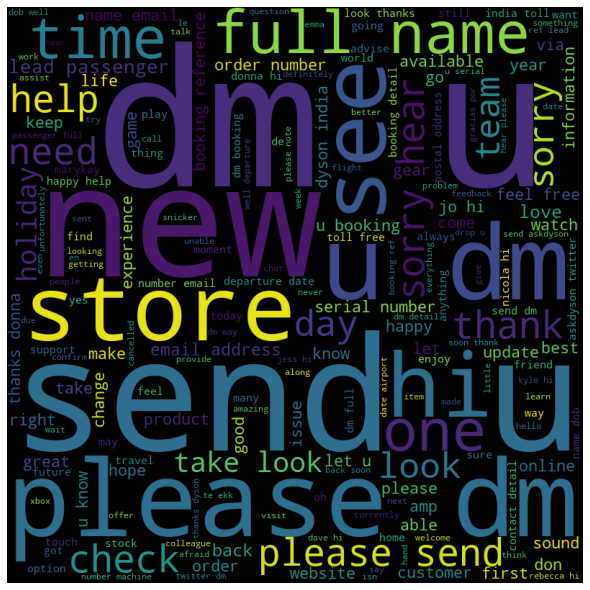

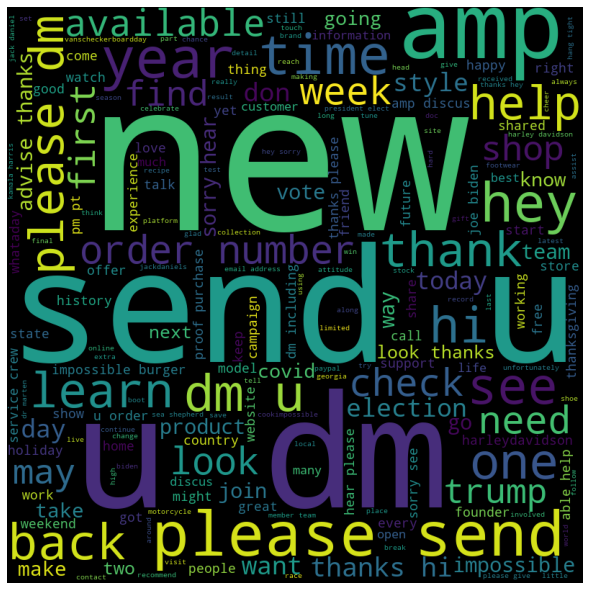

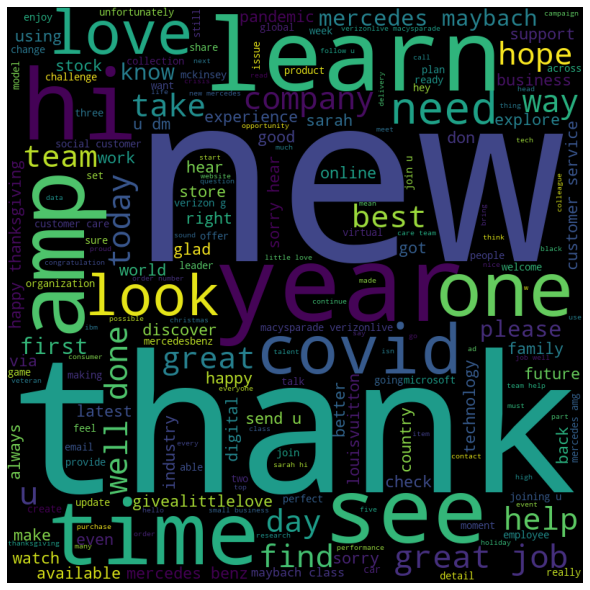

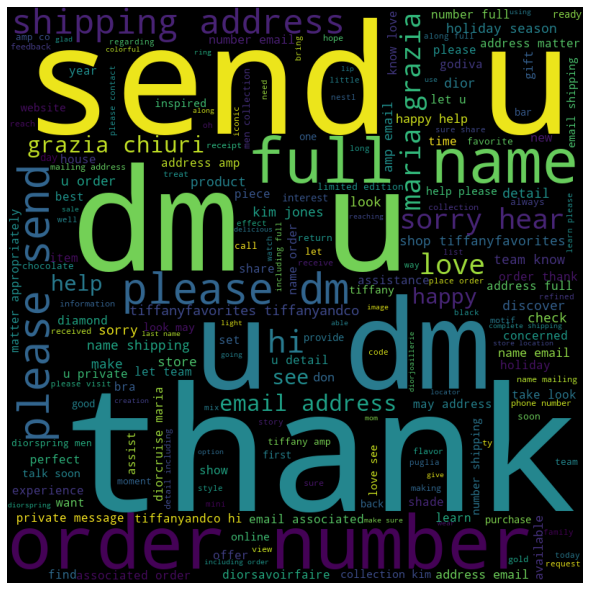

In [35]:
# Plot word cloud for every archetype
for arch in archetype_list:
    plot_word_cloud_for_category(df_tweets, arch)

In [36]:
# Create datasets
df_x = df_tweets['processed_tweet']
df_y = df_tweets['archetype']

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator
import multiprocessing
from sklearn import utils as skl_utils
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

class Text2TfIdfTransformer(BaseEstimator):

    def __init__(self):
        self._model = TfidfVectorizer()
        pass

    def fit(self, df_x, df_y=None):
        self._model.fit(df_x)
        return self

    def transform(self, df_x):
        return self._model.transform(df_x)

In [38]:
# Calculate TF-IDF
tfidf_transformer = Text2TfIdfTransformer()
tfidf_vectors = tfidf_transformer.fit(df_x).transform(df_x)

In [39]:
from sklearn.linear_model import LogisticRegression

pl_log_reg_tf_idf = Pipeline(steps=[('tfidf',Text2TfIdfTransformer()),
                             ('log_reg', LogisticRegression(multi_class='multinomial', solver='saga', max_iter=100))])
scores = cross_val_score(pl_log_reg_tf_idf, df_x, df_y, cv=5,scoring='accuracy')
print('Accuracy for Tf-Idf & Logistic Regression: ', scores.mean())

Accuracy for Tf-Idf & Logistic Regression:  0.5976698897011573


In [40]:
# XGBoost
import xgboost as xgb

pl_xgb_tf_idf = Pipeline(steps=[('tfidf',Text2TfIdfTransformer()),
                         ('xgboost', xgb.XGBClassifier(objective='multi:softmax'))])
scores = cross_val_score(pl_xgb_tf_idf, df_x, df_y, cv=5)
print('Accuracy for Tf-Idf & XGBoost Classifier : ', scores.mean())

Accuracy for Tf-Idf & XGBoost Classifier :  0.587538509556245


In [41]:
# Apply K-Means to the dataset

vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=25000)
start = time.time()
vectorizer.fit(df_tweets['processed_tweet'])
print(f'Vectorizer fitting ended in {round(time.time()-start)} seconds')
print(f'Number of feature_words: {len(vectorizer.get_feature_names())}')

import time
start = time.time()
kmpp = KMeans(n_clusters=12, init='k-means++', n_init=1, max_iter=10000, tol=1e-5, random_state=1)
kmpp.fit(tfidf_vectors)
print(f'KMeans++ model training finished in {round(time.time() - start)} seconds.')

show_training_results(kmpp, 12) 

In [48]:
to_predict = tfidf_transformer.transform(df_tweets['processed_tweet'])
pred = kmpp.predict(to_predict)



Tweet: hard work paid off awesome  - archetype: artist => prediction: 10
Tweet: great way surprise loved one  - archetype: artist => prediction: 10
Tweet: bring fun home relive favorite childhood memory sesame street  - archetype: artist => prediction: 10
Tweet: happy birthday master builder hope magical day  - archetype: artist => prediction: 10
Tweet:  - archetype: artist => prediction: 10
Tweet:  - archetype: artist => prediction: 10
Tweet: way  - archetype: artist => prediction: 10
Tweet: time add bit legodots hocus pocus animal crossing island scan code nooklink app add collection acnh dotyourworld  - archetype: artist => prediction: 10
Tweet: make ninja neighborhood jealous look ninja tastic  - archetype: artist => prediction: 10
Tweet: boo  - archetype: artist => prediction: 10
Tweet: spooky ride  - archetype: artist => prediction: 10
Tweet: brick lantern certainly treat no trick get building halloween rebuildtheworld  - archetype: artist => prediction: 10
Tweet:  - archetype: a

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

